In [34]:
from itertools import count

import pandas as pd
from numpy.ma.core import shape
from umap import UMAP

from sklearn.cluster import HDBSCAN
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from bertopic import BERTopic

***UTILS***

In [35]:
def get_balanced_random_subset(df, n_categories):
    # select n elements from each category
    balanced_random_subset = []
    for category in df["category"].unique():
        category_subset = df[df["category"] == category]
        category_subset = category_subset.sample(n=n_categories, random_state=42, replace=True)
        balanced_random_subset.append(category_subset)

    return pd.concat(balanced_random_subset)


def preprocess_text(text):
    # Tokenize and convert to lowercase
    tokens = word_tokenize(text.lower())

    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)


***DATASET MANAGEMENT***

In [36]:

# management for news dataset
"""dataframe = pd.read_csv("data/news_balanced_dataset.csv")
dataframe = dataframe.dropna()
reduced_dataset = get_balanced_random_subset(dataframe, 2000)
documents = reduced_dataset["short_description"].tolist()"""


# management for books dataset

dataframe = pd.read_csv("data/BooksDatasetClean.csv")
dataframe = dataframe.dropna()
#get N random element from the datafram
dataframe = dataframe.sample(n=24000)
documents = dataframe["Description"].tolist()

# text cleaning
documents = [preprocess_text(document) for document in documents]

***EMBEDDINGS GENERATION***

In [37]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("thenlper/gte-small", cache_folder="model", local_files_only = True)
embeddings = model.encode(documents, show_progress_bar=True, random_state=42)

# np.save('book_embeddings_big.npy', embeddings)

# Load Embeddings if already generated
# embeddings = np.load('book_embeddings_big.npy')
print(embeddings.shape)

Batches: 100%|██████████| 750/750 [01:14<00:00, 10.12it/s]

(24000, 384)


***EMBEDDING SIZE REDUCTION***

In [38]:


umap_model = UMAP(n_components=6, min_dist=0.0, metric="cosine", random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

***CLUSTERING***

In [39]:
hdbscan_model = HDBSCAN(
    min_cluster_size=400,
    min_samples=5,
    metric='cosine',
    cluster_selection_method='leaf',
    algorithm='auto',
    leaf_size=40,
    n_jobs=-1
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_

df = pd.DataFrame(reduced_embeddings, columns=range(6))
df["documents"] = documents
df["cluster"] = [str(c) for c in clusters]


print("CLUSTERS FREQUENCIES:")
print(df["cluster"].value_counts())

CLUSTERS FREQUENCIES:
cluster
-1    11534
1      1157
14      989
5       924
7       877
8       838
9       806
10      796
15      770
3       661
11      646
4       627
13      624
12      478
0       476
6       463
17      462
2       444
16      428
Name: count, dtype: int64


***Visual Rapresentaion of the Clusters***

CLUSTERS FREQUENCIES:
cluster
-1    11534
1      1157
14      989
5       924
7       877
8       838
9       806
10      796
15      770
3       661
11      646
4       627
13      624
12      478
0       476
6       463
17      462
2       444
16      428
Name: count, dtype: int64


/var/folders/n3/w2kc2s3d6t76l6jbt7gd52tc0000gn/T/ipykernel_17909/1712401540.py:24: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



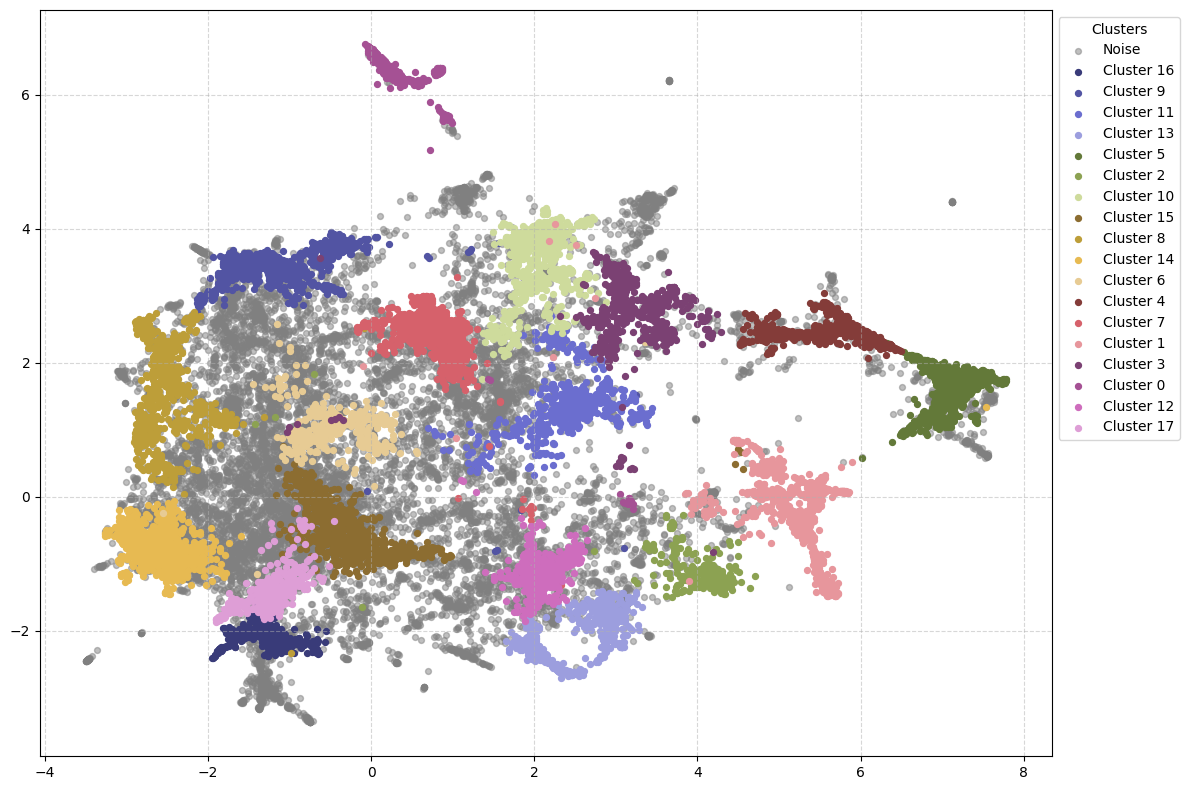

In [40]:

two_dim_embeddings = UMAP(n_components=2, min_dist=0, metric="cosine", random_state=42).fit_transform(embeddings)

df = pd.DataFrame(two_dim_embeddings, columns=["x", "y"])
df["documents"] = documents
df["cluster"] = [str(c) for c in clusters]


print("CLUSTERS FREQUENCIES:")
print(df["cluster"].value_counts())


# get elements to plot
to_plot_df = df.loc[df.cluster != "-1", :]
# get the noise elements
outliers_df = df.loc[df.cluster == "-1", :]


plt.figure(figsize=(12, 8))


plt.scatter(outliers_df.x, outliers_df.y, c="grey", label=f"Noise", alpha=0.5, s=18)

unique_labels = to_plot_df["cluster"].unique()
colors = plt.cm.get_cmap("tab20b", len(unique_labels))

for idx, cluster_label in enumerate(unique_labels):
    cluster_points = to_plot_df[to_plot_df["cluster"] == cluster_label]
    plt.scatter(cluster_points.x, cluster_points.y, color=colors(idx), label=f"Cluster {cluster_label}", s=18)
    plt.grid(True, linestyle='--', alpha=0.5)

#show the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Clusters")

plt.tight_layout()
plt.show()


***TOPIC MODELLING***

In [41]:
topic_model = BERTopic(embedding_model = model,
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       verbose=True).fit(documents, embeddings)

topics = topic_model.get_topics()

#show all topic in the bar chart
fig = topic_model.visualize_barchart(topics=topics)
fig.write_html("topic_barchart.html")

2025-09-06 17:29:42,943 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-06 17:29:56,882 - BERTopic - Dimensionality - Completed ✓
2025-09-06 17:29:56,885 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-06 17:30:25,911 - BERTopic - Cluster - Completed ✓
2025-09-06 17:30:25,920 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-06 17:30:26,939 - BERTopic - Representation - Completed ✓


In [43]:


k = 5

for n in range(-1, (len(topics) - 1)):
    print(" ")
    print(f"Topic {n}:")
    target_topic = topics[n]
    for i in range(k):
        term = target_topic[i][0]
        weight = target_topic[i][1]
        print(f"{term}:{weight:.2f}, ", end='')


 
Topic -1:
life:0.02, book:0.01, new:0.01, one:0.01, world:0.01,  
Topic 0:
garden:0.03, color:0.03, project:0.03, step:0.03, design:0.03,  
Topic 1:
murder:0.03, killer:0.03, case:0.02, crime:0.02, one:0.02,  
Topic 2:
recipe:0.09, dish:0.05, food:0.04, cooking:0.04, cookbook:0.03,  
Topic 3:
god:0.07, jesus:0.04, church:0.04, bible:0.04, christian:0.03,  
Topic 4:
war:0.05, world:0.02, american:0.02, military:0.02, battle:0.02,  
Topic 5:
president:0.03, political:0.03, bush:0.02, american:0.02, america:0.02,  
Topic 6:
business:0.05, company:0.02, management:0.02, book:0.02, organization:0.02,  
Topic 7:
life:0.03, friend:0.02, love:0.02, new:0.02, novel:0.02,  
Topic 8:
student:0.05, writing:0.03, guide:0.02, word:0.02, college:0.02,  
Topic 9:
child:0.06, parent:0.05, family:0.02, book:0.02, help:0.02,  
Topic 10:
weight:0.05, diet:0.05, food:0.04, health:0.04, body:0.03,  
Topic 11:
dog:0.09, cat:0.05, animal:0.05, pet:0.04, owner:0.03,  
Topic 12:
child:0.05, book:0.04, little:

***Parallel Coordinates***

In [45]:
# Parallel Coordinates
import plotly.graph_objects as go

# Select a fow embeddings for better visibility and filter out noise clusters
sample_embeddings = reduced_embeddings[:200]
sample_clusters = clusters[:200]

# Remove noise points (cluster -1)
mask = sample_clusters != -1
filtered_embeddings = sample_embeddings[mask]
filtered_clusters = sample_clusters[mask]

dimensions = [dict(range=[filtered_embeddings[:, i].min(), filtered_embeddings[:, i].max()],
                   label=f'Dimension {i + 1}',
                   values=filtered_embeddings[:, i]) for i in range(6)]

# Create color mapping for clusters
unique_clusters = sorted(set(filtered_clusters))
cluster_labels = [f'Cluster {c}' for c in unique_clusters]

fig = go.Figure(data=
go.Parcoords(
    line=dict(color=filtered_clusters,
              colorscale='Viridis',
              showscale=True,
              colorbar=dict(
                  ticktext=cluster_labels,
                  tickvals=unique_clusters,
                  title='Clusters'
              )),
    dimensions=dimensions
)
)

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    title='Parallel Coordinates Plot of 6D UMAP Embeddings'
)

fig.show()
fig.write_html("parallel_coordinates.html")


In [54]:
print(dataframe.info())

<class 'pandas.core.frame.DataFrame'>
Index: 24000 entries, 77774 to 90709
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Title                    24000 non-null  object 
 1   Authors                  24000 non-null  object 
 2   Description              24000 non-null  object 
 3   Category                 24000 non-null  object 
 4   Publisher                24000 non-null  object 
 5   Price Starting With ($)  24000 non-null  float64
 6   Publish Date (Month)     24000 non-null  object 
 7   Publish Date (Year)      24000 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 1.6+ MB
None
